## Importing the goodies


In [391]:
import numpy as np
import torch
import torch.nn as nn      
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cv2
from PIL import Image
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
import tqdm

## Defining some utils which are required for preprocessing within the CNN
* `batch_to_canny()` converts a batch of images to binary images with only the edges defined 
* `np_arr_to_canny_edges()` converts a single grayscale image (2D numpy array) to canny edges

In [2]:
def batch_to_canny(tensor_batch):
    batch = []
    tensor_batch = tensor_batch.view(-1,tensor_batch.size()[-2], tensor_batch.size()[-1] )
    for image in tensor_batch:

        foo = (image.numpy().astype(np.uint8))
        ed = np_arr_to_canny_edges(foo)
        batch.append(ed)

    foo = torch.Tensor(batch)
    foo = foo.view(-1,1, foo.size()[1], foo.size()[2])
    return foo
def np_arr_to_canny_edges(im_arr):
    ed = cv2.Canny(im_arr.astype(np.uint8), 100,100)
    return ed

## Defining the CNN layers and loading trained weights 
* the CNN was trained in [parallel_CNNs.ipynb](!https://github.com/Mayukhdeb/adventures-with-augmentation/blob/master/parallel_CNNs.ipynb)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 10, 3),
            nn.MaxPool2d(5,5),
            nn.ReLU(inplace=True),
            nn.Conv2d(10, 10, 3),
            nn.MaxPool2d(3,3),
            nn.ReLU(inplace=True),
            nn.Conv2d(10, 10, 3),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(150, 110),
            nn.ReLU(inplace=True),
            nn.Linear(110, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 4),
        )
    def forward(self, x):
        x = batch_to_canny(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

cellnet_1 = Net()
cellnet_1.load_state_dict(torch.load("cellnet_1.pt"))

<All keys matched successfully>

In [127]:
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.pool = nn.MaxPool2d(3,3)
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(4, 8, 5)

        self.fc1 = nn.Linear(704,200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 20)

        self.fc4 = nn.Linear(20, 4)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = (self.fc4(x))      ## removed relu
        return x

cellnet_2 = Net_2()
cellnet_2.load_state_dict(torch.load("cellnet_2.pt"))

<All keys matched successfully>

## Preprocessing an image to a 4D tensor to be fed to the CNN
*  The 2D grayscale image is unsqueezed twice to give it a rank of 4

In [5]:
def preprocess(img_path, show = False):
    im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(im, (120, 90))
    if show == True:
        plt.imshow(im, cmap = "gist_earth")
        plt.xlabel("Original image", fontsize = 20)
        plt.show()
    inp = torch.from_numpy(im).unsqueeze(0).unsqueeze(0).float()  ## tensor ready to be fed to nn 
    
    return inp 

In [6]:
def show_layers(model, image_tensor, layer_number):
    features = nn.Sequential(*list(cellnet_1.children())[:layer_number])
    mm = features(inp).detach().numpy()
    images = []
    for i in mm[0]:
        images.append(i)
    f = plt.figure(figsize = (35,20))
    for m in range (1,len(images)):
        f.add_subplot(1,len(images), m)

        plt.imshow(images[m], cmap = 'gnuplot2', label = "Canny")
    plt.show()

## Plotting trained weights from the CNN



In [7]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  #extracting the model features at the particular layer number
    layer = model.features[layer_num]
  #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data

        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)

        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")
    else:
        print("Can only visualize layers which are convolutional")
        
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
    plt.tight_layout()
    plt.show()


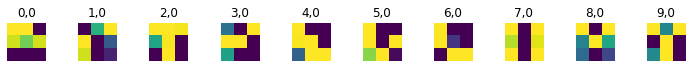

In [8]:
plot_weights(cellnet_1, 0, single_channel = True)
# plot_weights(cellnet_1, 3, single_channel = True)
# plot_weights(cellnet_1, 6, single_channel = True)

## Plotting the heatmap of activations from the CNN forward pass 
* returns a heatmap of activations 
* values vary from 0.0 to 1.0 (probability)

In [11]:
def occlusion(model, image, label, occ_size = 10, occ_stride = 10, occ_pixel = 0.5, replace_pixel_with_label = False):
    #get the width and height of the image
    
    width, height = image.shape[-2], image.shape[-1]
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_width, output_height))
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image).flatten()
            
            if replace_pixel_with_label == True:
            
                heatmap[w,h] = torch.argmax(output).item()    ## replacing pixels
                
            else:
                output = nn.functional.softmax(output, dim = 0)

                prob = output.squeeze()[label].item()
                heatmap[w,h] = 1 - prob    ## replacing pixels
  
    return heatmap

## Plotting the original image for reference



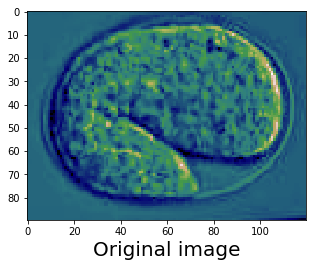

In [646]:
inp = preprocess("c2.jpg", show = True)

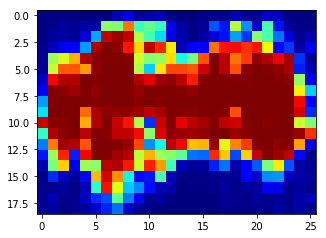

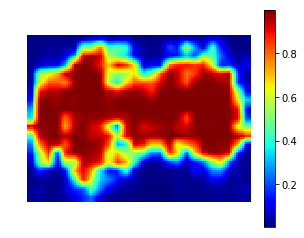

In [647]:
rcParams['figure.figsize'] = 5, 4
heatmap = occlusion(cellnet_1, inp,1, 16, 4).numpy()

plt.imshow(heatmap)
plt.show()
overlay = cv2.resize(heatmap, (120,90))
plt.set_cmap("jet")
plt.imshow(overlay)
plt.colorbar()
plt.axis('off')
plt.show()
plt.imsave("heat.jpg", overlay)

# Superimposing the heatmap on the original image
* The red zones indicate the regions which got the most activations for the given class
* In simpler words, the CNN "looks" at these parts of the image and comes to the conclusion that it belongs to a certain label
* `cv2.addWeighted()` has arguments "alpha" and "beta" after each image argument. Alpha = 1 and Beta = 0 means it'll return a copy of the original image.

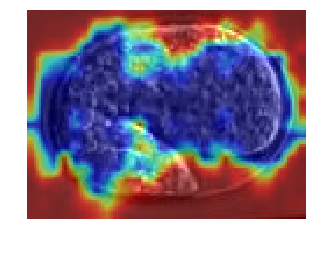

In [648]:
img = cv2.resize(cv2.imread("c2.jpg"), (120,90))
mapp= cv2.resize(cv2.imread("heat.jpg"), (120,90))

fin = cv2.addWeighted(img, 0.7, mapp, 0.6, 0)
plt.imshow(fin)
plt.axis("off")
plt.xlabel("Class activation heatmap superimposed on the original image ")
plt.show()

In [649]:
def show_heatmap_from_model(model, image_path, label, heatmap_kernel_size, stride_size = 4, show_heatmap = False, class_label_heatmap = False):
    inp = preprocess(image_path, show = False)
    heatmap = occlusion(model, inp,label, heatmap_kernel_size, stride_size, replace_pixel_with_label = class_label_heatmap).numpy()
    if show_heatmap == True:
        plt.imshow(heatmap)
        plt.colorbar()
        plt.show()
    
    image_shape = (cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).shape)[::-1]
    overlay = cv2.resize(heatmap, image_shape)
    
    
    plt.imsave("heatmap.jpg", overlay)
    img = cv2.resize(cv2.imread(image_path), image_shape)
    mapp= cv2.resize(cv2.imread("heatmap.jpg"), image_shape)
    

    fin = cv2.addWeighted(img, 0.7, mapp, 0.6, 0)
    
    return fin

In [650]:
heatmaps_model_1 = [
show_heatmap_from_model(cellnet_1, "gastrula.png", label = 0, heatmap_kernel_size = 16, stride_size = 4, show_heatmap = False),
show_heatmap_from_model(cellnet_1, "comma.png", label = 1, heatmap_kernel_size = 16, show_heatmap = False),
show_heatmap_from_model(cellnet_1, "fold.png", label = 2, heatmap_kernel_size = 16, show_heatmap = False),
show_heatmap_from_model(cellnet_1, "l1.png", label = 3, heatmap_kernel_size = 16, show_heatmap = False),
]
heatmaps_model_2 = [
show_heatmap_from_model(cellnet_2, "gastrula.png", label = 0, heatmap_kernel_size = 16, show_heatmap = False),
show_heatmap_from_model(cellnet_2, "comma.png", label = 1, heatmap_kernel_size = 16, show_heatmap = False),
show_heatmap_from_model(cellnet_2, "fold.png", label = 2, heatmap_kernel_size = 16, show_heatmap = False),
show_heatmap_from_model(cellnet_2, "l1.png", label = 3, heatmap_kernel_size = 16, show_heatmap = False),
]

# Comparing class activation maps of two different architectures
* The images to the left are from a model where the image undergoes decomposition by `cv2.Canny()`
* In simpler words, the blue regions represent the parts of the image which made the CNN decide that it belongs to a certain class

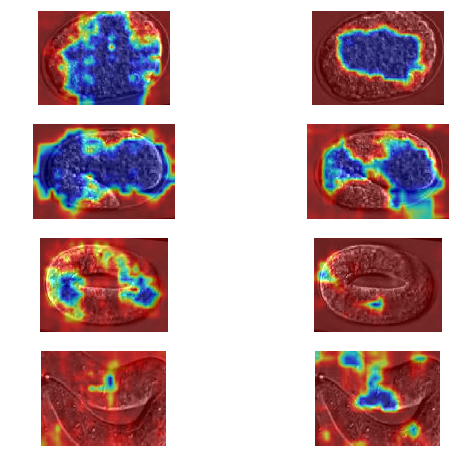

In [653]:
rcParams['figure.figsize'] = 9, 8
fig, ax = plt.subplots(4,2)
for i in range(4):
    ax[i][0].imshow(heatmaps_model_1[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(heatmaps_model_2[i])
    ax[i][1].axis("off")

## Detecting and marking cells from images
* It's just an improvisation over the `occlusion()` function written above.
* `generate_heatmap()` generates a heatmap where it marks the possible positions of the image.
> * it iterates through the image and takes small samples of size (kernel_size * kernel_size)
> * The smaller samples are resized and passed through the CNN, which returns the probability of the occurrence of the given label.
> * These probability values are used to make the heatmap
* `detect_cell_heatmap()` makes everyting more modular, and builds a pipeline that works on images straight from the storage
> * Try not to keep the stride size too low. Smaller the stride size, the more time it takes for the heatmap to be generated.

In [489]:
def generate_heatmap(input_tensor, model, kernel_size, stride, thresh_prob):
    image = input_tensor
    width, height = image.shape[-2], image.shape[-1]
    #setting the output image width and height
    output_height = int(np.ceil((height-kernel_size)/stride))
    output_width = int(np.ceil((width-kernel_size)/stride))
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_width, output_height))
    for h in range(0, height):
        for w in range(0, width):
            h_start = h*stride
            w_start = w*stride
            h_end = min(height, h_start + kernel_size)
            w_end = min(width, w_start + kernel_size)
            if (w_end) >= width or (h_end) >= height:
                continue
            input_image = image.clone().detach()
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            sweet_slice = cv2.resize(input_image[:, :, w_start:w_end, h_start:h_end].squeeze(0).squeeze(0).numpy(), (120,90))
            sweet_tensor =  torch.from_numpy(sweet_slice).unsqueeze(0).unsqueeze(0)
            output = model(sweet_tensor).flatten()
            output = torch.softmax(output, dim = 0)[label].item()
            if  1- output > thresh_prob:
                heatmap[w,h] = 1 -  output    
            else:
                heatmap[w,h] =  0   
    return heatmap.detach().numpy()

In [656]:
def detect_cell_heatmap(model, image_path, kernel_size, stride, label, threshold_prob):
    
    im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    input_tensor = torch.from_numpy(im).unsqueeze(0).unsqueeze(0).float()  ## tensor ready to be fed to nn 
    heatmap = generate_heatmap(input_tensor, model, kernel_size, stride, threshold_prob)
    heatmap = cv2.resize(heatmap, im.shape[::-1])
    plt.imsave("heatmap.png", heatmap)
    fin = cv2.addWeighted(cv2.imread(image_path), 0.9,cv2.imread("heatmap.png"),0.5, 0)
#     heatmap = cv2.Canny(cv2.imread("heatmap.png",  cv2.IMREAD_GRAYSCALE),100,10)
    f , axarr = plt.subplots(1,3)
    axarr[0].imshow(im, cmap = "gray")
    axarr[1].imshow(heatmap)
    axarr[2].imshow(fin)

## Trying on images of single cells first
* The kernel size has been set as per the approximate size of the cell in the image
* a larger stride size gives us a "coarse" heatmap

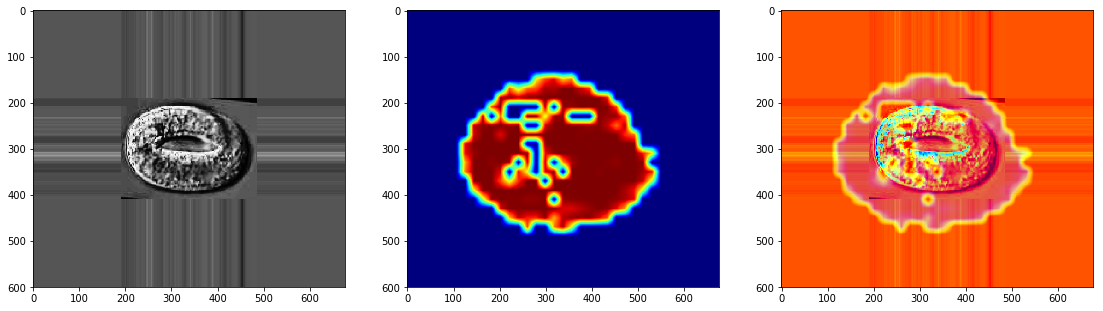

In [658]:
rcParams['figure.figsize'] = 19, 12
detect_cell_heatmap(model = cellnet_2, image_path = "fold_big.png", kernel_size = 120, stride = 16, label = 2, threshold_prob =0.5)

## Works just fine when it has to detect multiple cells within a single image
* But this time around, the kernel size is much larger. This is to accomodate for the larger image, and hence the larger cell.

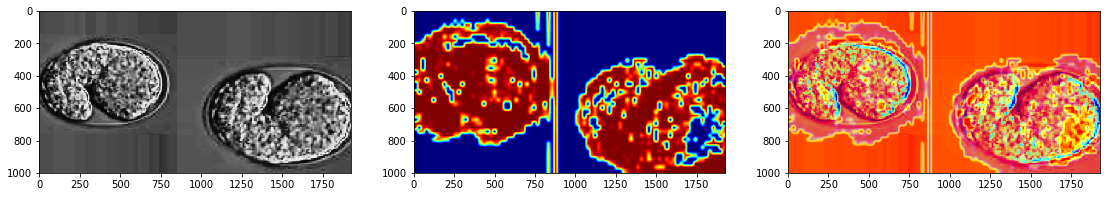

In [659]:
detect_cell_heatmap(model = cellnet_2, image_path = "combo.jpg", kernel_size = 190, stride = 20, label = 1, threshold_prob =0.5)